## Collaborative recommend system on real dataset using `surprise`
### Playground from intensive, day 2, part 2

In [1]:
import pandas as pd
from plotly.graph_objects import *

from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic, KNNWithMeans
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

### Training dataset

In [2]:
df = pd.read_csv('datasets/book-crossing/users-ratings.csv')

df = df[df['Rating'] != 0]

df.head()

,User-ID,Age,ISBN,Rating
0,243,NaN,0060915544,10
1,243,NaN,0060977493,7
4,243,NaN,0316601950,9
8,243,NaN,0316776963,9
9,243,NaN,0316899984,7


In [3]:
reader = Reader(rating_scale=(1, 10))

df.head()

,User-ID,Age,ISBN,Rating
0,243,NaN,0060915544,10
1,243,NaN,0060977493,7
4,243,NaN,0316601950,9
8,243,NaN,0316776963,9
9,243,NaN,0316899984,7


In [4]:
data = Dataset.load_from_df(df[["User-ID", "ISBN", "Rating"]], reader)

In [5]:
sim_options = {
    "name": "cosine",
    "user_based": False,
}
algo = KNNBasic(sim_options=sim_options)

In [6]:
train_set = data.build_full_trainset()

In [7]:
algo.fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [8]:
df.head()

,User-ID,Age,ISBN,Rating
0,243,NaN,0060915544,10
1,243,NaN,0060977493,7
4,243,NaN,0316601950,9
8,243,NaN,0316776963,9
9,243,NaN,0316899984,7


In [9]:
prediction = algo.predict(243, "0060915544")

prediction

Prediction(uid=243, iid='0060915544', r_ui=None, est=7.794547301085934, details={'actual_k': 14, 'was_impossible': False})

In [10]:
train, test = train_test_split(data, test_size=0.1)

In [11]:
algo.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [12]:
predictions = algo.test(test)

### Metrics

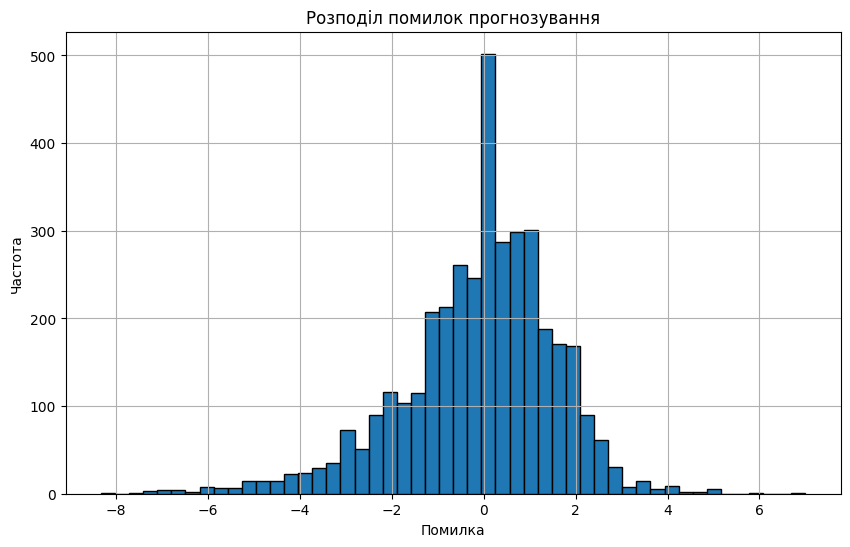

In [13]:
import matplotlib.pyplot as plt

errors = [pred.r_ui - pred.est for pred in predictions]

plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='k')
plt.title('Розподіл помилок прогнозування')
plt.xlabel('Помилка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

In [14]:
like_threshold = 7

hits = [1 for pred in predictions if pred.r_ui >= like_threshold and pred.est >= like_threshold]

hit_rate = sum(hits) / len(predictions)

hit_rate

0.728417738126476

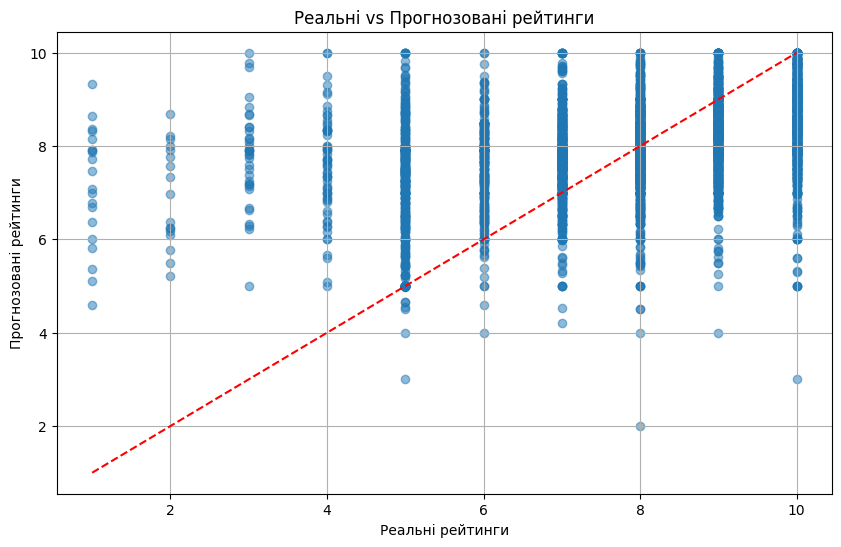

In [15]:
real_ratings = [pred.r_ui for pred in predictions]
predicted_ratings = [pred.est for pred in predictions]

plt.figure(figsize=(10, 6))
plt.scatter(real_ratings, predicted_ratings, alpha=0.5)
plt.plot([min(real_ratings), max(real_ratings)], [min(real_ratings), max(real_ratings)], color='red', linestyle='--')
plt.title('Реальні vs Прогнозовані рейтинги')
plt.xlabel('Реальні рейтинги')
plt.ylabel('Прогнозовані рейтинги')
plt.grid(True)
plt.show()

### Cross-validate

In [16]:
cross_validate(algo, data, measures=["RMSE", "MSE"], cv=3, verbose=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.7112  1.7127  1.7265  1.7168  0.0069  
MSE (testset)     2.9283  2.9334  2.9808  2.9475  0.0236  
Fit time          0.04    0.05    0.05    0.05    0.00    
Test time         0.19    0.15    0.15    0.16    0.02    


{'test_rmse': array([1.71122769, 1.7127257 , 1.72649748]),
 'test_mse': array([2.92830022, 2.93342932, 2.98079356]),
 'fit_time': (0.04428291320800781, 0.04693794250488281, 0.0482480525970459),
 'test_time': (0.19015812873840332, 0.15243101119995117, 0.15227389335632324)}

### Grid search

In [17]:
sim_options = {
    "name": ["cosine", "msd"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
}

param_grid = {"sim_options": sim_options}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
gs.fit(data)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

In [18]:
gs.best_score["rmse"]

1.7427210245566525

In [19]:
gs.best_params

{'rmse': {'sim_options': {'name': 'cosine',
   'min_support': 5,
   'user_based': False}},
 'mae': {'sim_options': {'name': 'cosine',
   'min_support': 3,
   'user_based': False}}}